# EDA

In [37]:
import pandas as pd
import numpy as np

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

******

************

## 1. Consulta a la base de datos

In [2]:
import pymysql
import pandas as pd

class DatabaseConnection:
    def __init__(self, password, username="usuario1",
                 host="database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
                 port=3306,
                 database="data"):
        self.host = host
        self.port = port
        self.username = username
        self.password = password
        self.database = database

    # Function to execute a query and return a Pandas DataFrame
    def query_to_df(self, query):
        # Establish connection using pymysql directly
        connection = pymysql.connect(
            host=self.host,
            user=self.username,
            password=self.password,
            db=self.database,
            port=self.port
        )
        # Execute query and fetch data into a DataFrame
        try:
            df = pd.read_sql(query, connection)
        finally:
            connection.close()
        return df


In [3]:
# Query to get all tables in the current database
query_show_tables = "SHOW TABLES"
database = DatabaseConnection("C0d35p4ce.")

# Fetch the list of tables and print them
tables = database.query_to_df(query_show_tables)
print("Tables in the database:")
print(tables)


Tables in the database:
           Tables_in_data
0  ventas_diarias_estudio


In [4]:
# Define the query
query_daily_and_top = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia
FROM ventas_diarias_estudio
"""

# Instantiate the class with the password
database = DatabaseConnection("C0d35p4ce.") 

# Execute the query and fetch results into a DataFrame
ventas = database.query_to_df(query_daily_and_top)

# Convert 'fecha_venta' to date format and 'articulo' to integer
ventas = ventas.assign(
    fecha_venta=pd.to_datetime(ventas["fecha_venta"])
).astype({"articulo": int})

# The 'ventas' DataFrame should now contain the query results
print(ventas.head())

    familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA      3960  2021-05-18    None   2.318     216.0  500.688008   
1  BOLLERIA      6286  2021-08-29    None   3.136      99.0  310.464005   
2  BOLLERIA      3880  2021-09-21    None   3.000     102.0  306.000000   
3  BOLLERIA      5803  2021-10-21    None   3.000      42.0  126.000000   
4  BOLLERIA      3880  2021-12-07    None   3.000     141.0  423.000000   

   orden_articulo_familia  
0                       1  
1                       4  
2                       3  
3                       5  
4                       3  


In [5]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10574 non-null  object        
 1   articulo                10574 non-null  int64         
 2   fecha_venta             10574 non-null  datetime64[ns]
 3   festivo                 837 non-null    object        
 4   precio                  10574 non-null  float64       
 5   cantidad                10574 non-null  float64       
 6   importe                 10574 non-null  float64       
 7   orden_articulo_familia  10574 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 661.0+ KB


In [81]:
ventas.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-18,None,2.318,216.0,500.688008,1
1,BOLLERIA,6286,2021-08-29,None,3.136,99.0,310.464005,4
2,BOLLERIA,3880,2021-09-21,None,3.000,102.0,306.000000,3
3,BOLLERIA,5803,2021-10-21,None,3.000,42.0,126.000000,5
4,BOLLERIA,3880,2021-12-07,None,3.000,141.0,423.000000,3


In [80]:
ventas['festivo'].unique()

array([None, 'Feria de Málaga', 'Noche de Halloween', 'Nochevieja',
       'Martes Santo', 'Día de la Hispanidad (Fiesta Nacional de España)',
       'Jueves Santo', 'Día de Todos los Santos', 'Navidad',
       'Día de la Madre', 'Lunes Santo', 'Día de la Constitución',
       'Día del Padre', 'Día de Reyes', 'Domingo de Ramos',
       'Viernes Santo', 'Día de San Valentín', 'Día de la Cruz',
       'Domingo de Resurrección', 'Día de la Virgen del Carmen',
       'Día de San Juan', 'Nochebuena', 'Miércoles Santo', 'Sábado Santo',
       'Año Nuevo', 'Fiesta de la Virgen de la Victoria',
       'Día de la Victoria'], dtype=object)

In [6]:
ventas.sample(10)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
1500,BOLLERIA,3960,2022-05-05,None,2.591,192.00,497.471999,1
1317,BOLLERIA,5803,2021-06-26,None,2.727,66.00,179.981995,5
9148,PANADERIA,1043,2022-01-04,None,2.740,201.00,550.740002,2
7647,BOLLERIA,6425,2021-05-18,None,31.364,16.38,513.742704,2
3766,BOLLERIA,3960,2022-06-07,None,2.591,180.00,466.379999,1
7102,PANADERIA,417,2022-12-26,None,4.615,33.00,152.295000,5
2968,PANADERIA,968,2022-09-10,None,2.452,204.00,500.208002,1
5221,PANADERIA,1084,2023-01-02,None,1.200,312.00,374.400004,4
8480,BOLLERIA,5803,2021-08-27,None,2.727,51.00,139.076996,5
3484,PASTELERIA,6523,2021-07-05,None,32.591,6.00,195.546005,3


******

***************

## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [7]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self):
        requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [8]:
# Fecha en la que comienza el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
start = ventas["fecha_venta"].min()

# Fecha en la que termina el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
end = ventas["fecha_venta"].max()

# Instancia la clase con el horizonte temporal a consultar
weather_query = DailyWeatherData(start, end)

# Obtener la info del tiempo del horizonte temporal consultado
weather = weather_query.get_weather_data()

weather.head()

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,272.0,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,206.0,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,132.0,13.8,1016.5


In [9]:
# ¿Hay nulls en los datos?
weather.isnull().sum()

time      0
tavg_w    0
tmin_w    0
tmax_w    0
prcp_w    0
wdir_w    0
wspd_w    0
pres_w    0
dtype: int64

In [10]:
weather.describe()

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
count,748,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,2022-05-09 12:00:00.000000256,19.368316,15.202674,24.881150,0.802005,214.978610,14.302406,1018.019786
min,2021-05-01 00:00:00,7.300000,1.100000,13.300000,0.000000,10.000000,6.100000,1004.400000
25%,2021-11-03 18:00:00,14.600000,10.900000,19.700000,0.000000,142.000000,10.900000,1014.500000
50%,2022-05-09 12:00:00,19.350000,14.700000,24.700000,0.000000,241.500000,12.500000,1017.250000
75%,2022-11-12 06:00:00,23.800000,19.900000,29.600000,0.000000,284.000000,16.800000,1021.000000
max,2023-05-18 00:00:00,33.500000,27.500000,42.600000,46.800000,356.000000,46.500000,1032.800000
std,NaN,5.344832,5.509558,5.924562,4.336827,74.300195,5.283497,5.126126


In [ ]:
weather.to_excel("20240319 variables meteorologicas.xlsx", "Data", index = False)

******

*********************

## 3. Join -> Datos de ventas y del tiempo

In [12]:
# Join del conjunto de datos de ventas y del tiempo por medio de la columna de fecha
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenar el dataframe
df.sort_values(["fecha_venta", "articulo"], inplace = True)

df.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
8674,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
7590,PANADERIA,900,2021-05-01,None,0.865,651.0,563.114998,3,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
4555,PANADERIA,968,2021-05-01,None,2.163,450.0,973.350002,1,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
6324,PANADERIA,1043,2021-05-01,None,2.596,327.0,848.892002,2,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
10514,PANADERIA,1084,2021-05-01,None,0.865,423.0,365.895005,4,17.2,11.9,22.8,0.0,282.0,14.2,1014.0


******

******

## 4. EDA

******

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

3. ¿Cuántos valores nulos hay en cada una de las variables?

4. ¿Hay duplicados?

In [14]:
#1.
df.sample(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
4143,PANADERIA,968,2023-05-05,None,2.550000,198.0,504.900000,1,19.2,15.4,23.9,0.0,95.0,12.0,1017.1
9692,PASTELERIA,6523,2022-04-19,None,39.544998,12.0,474.540009,3,18.1,13.0,26.7,0.0,295.0,11.9,1011.0
8248,BOLLERIA,3960,2021-09-01,None,2.318000,264.0,611.952005,1,25.9,22.4,31.2,0.0,133.0,10.6,1014.0
7388,PANADERIA,1084,2023-04-30,None,1.200000,219.0,262.799998,4,23.1,18.2,27.7,0.0,239.0,15.3,1014.9
6565,BOLLERIA,5803,2022-08-27,None,3.545000,90.0,319.050005,5,25.2,22.6,30.2,0.0,134.0,10.4,1011.3


In [22]:
# 2. Variables numéricas
df.describe()

,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
count,10574.000000,10574,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000
mean,3945.091734,2022-05-08 13:21:34.420276224,15.414053,137.687953,462.520794,2.961982,19.391290,15.222035,24.909504,0.780433,214.941933,14.324816,1018.017099
min,417.000000,2021-05-01 00:00:00,0.865000,1.200000,9.000000,1.000000,7.300000,1.100000,13.300000,0.000000,10.000000,6.100000,1004.400000
25%,1043.000000,2021-11-01 00:00:00,2.591000,15.000000,287.887500,2.000000,14.600000,10.900000,19.700000,0.000000,142.000000,10.900000,1014.500000
50%,5403.000000,2022-05-08 00:00:00,3.545000,84.000000,405.000000,3.000000,19.400000,14.700000,24.700000,0.000000,242.000000,12.500000,1017.200000
75%,6286.000000,2022-11-12 00:00:00,34.091000,219.000000,569.655075,4.000000,23.800000,19.900000,29.600000,0.000000,284.000000,16.800000,1021.000000
max,6549.000000,2023-05-18 00:00:00,43.500000,1110.000000,3271.929962,5.000000,33.500000,27.500000,42.600000,46.800000,356.000000,46.500000,1032.800000
std,2404.630373,NaN,17.003998,148.164571,274.155030,1.395454,5.349137,5.506365,5.931939,4.260470,74.290122,5.312566,5.112500


In [79]:
# 2. Variables categóricas
df.describe(include='object')

,familia,festivo
count,10574,837
unique,3,26
top,PANADERIA,Feria de Málaga
freq,3740,99


In [11]:
# 2
# La diferencia entre el número único de artículos y de precios muestra que los precios cambian a lo largo del tiempo

# Cardinalidad: número de valores diferentes
# Granularidad: cuánta variedad tienen los datos en relación con el total de registros. Porcentaje de valores únicos.

(
  df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(max))
    .assign(Min = df.dropna().apply(min))
    .sort_values(["Tipo"])
)

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
articulo,int64,15,0.141857,0.000000,6549,417
fecha_venta,datetime64[ns],748,7.073955,0.000000,2023-05-07 00:00:00,2021-05-02 00:00:00
orden_articulo_familia,int64,5,0.047286,0.000000,5,1
precio,float64,45,0.425572,0.000000,43.5,0.865
cantidad,float64,1418,13.410252,0.000000,966.0,2.88
importe,float64,6303,59.608474,0.000000,2377.851974,85.080002
tavg_w,float64,200,1.891432,0.000000,31.1,11.1
tmin_w,float64,214,2.023832,0.000000,26.3,5.2
tmax_w,float64,221,2.090032,0.000000,39.2,15.0
prcp_w,float64,59,0.557972,0.000000,24.1,0.0


<Axes: >

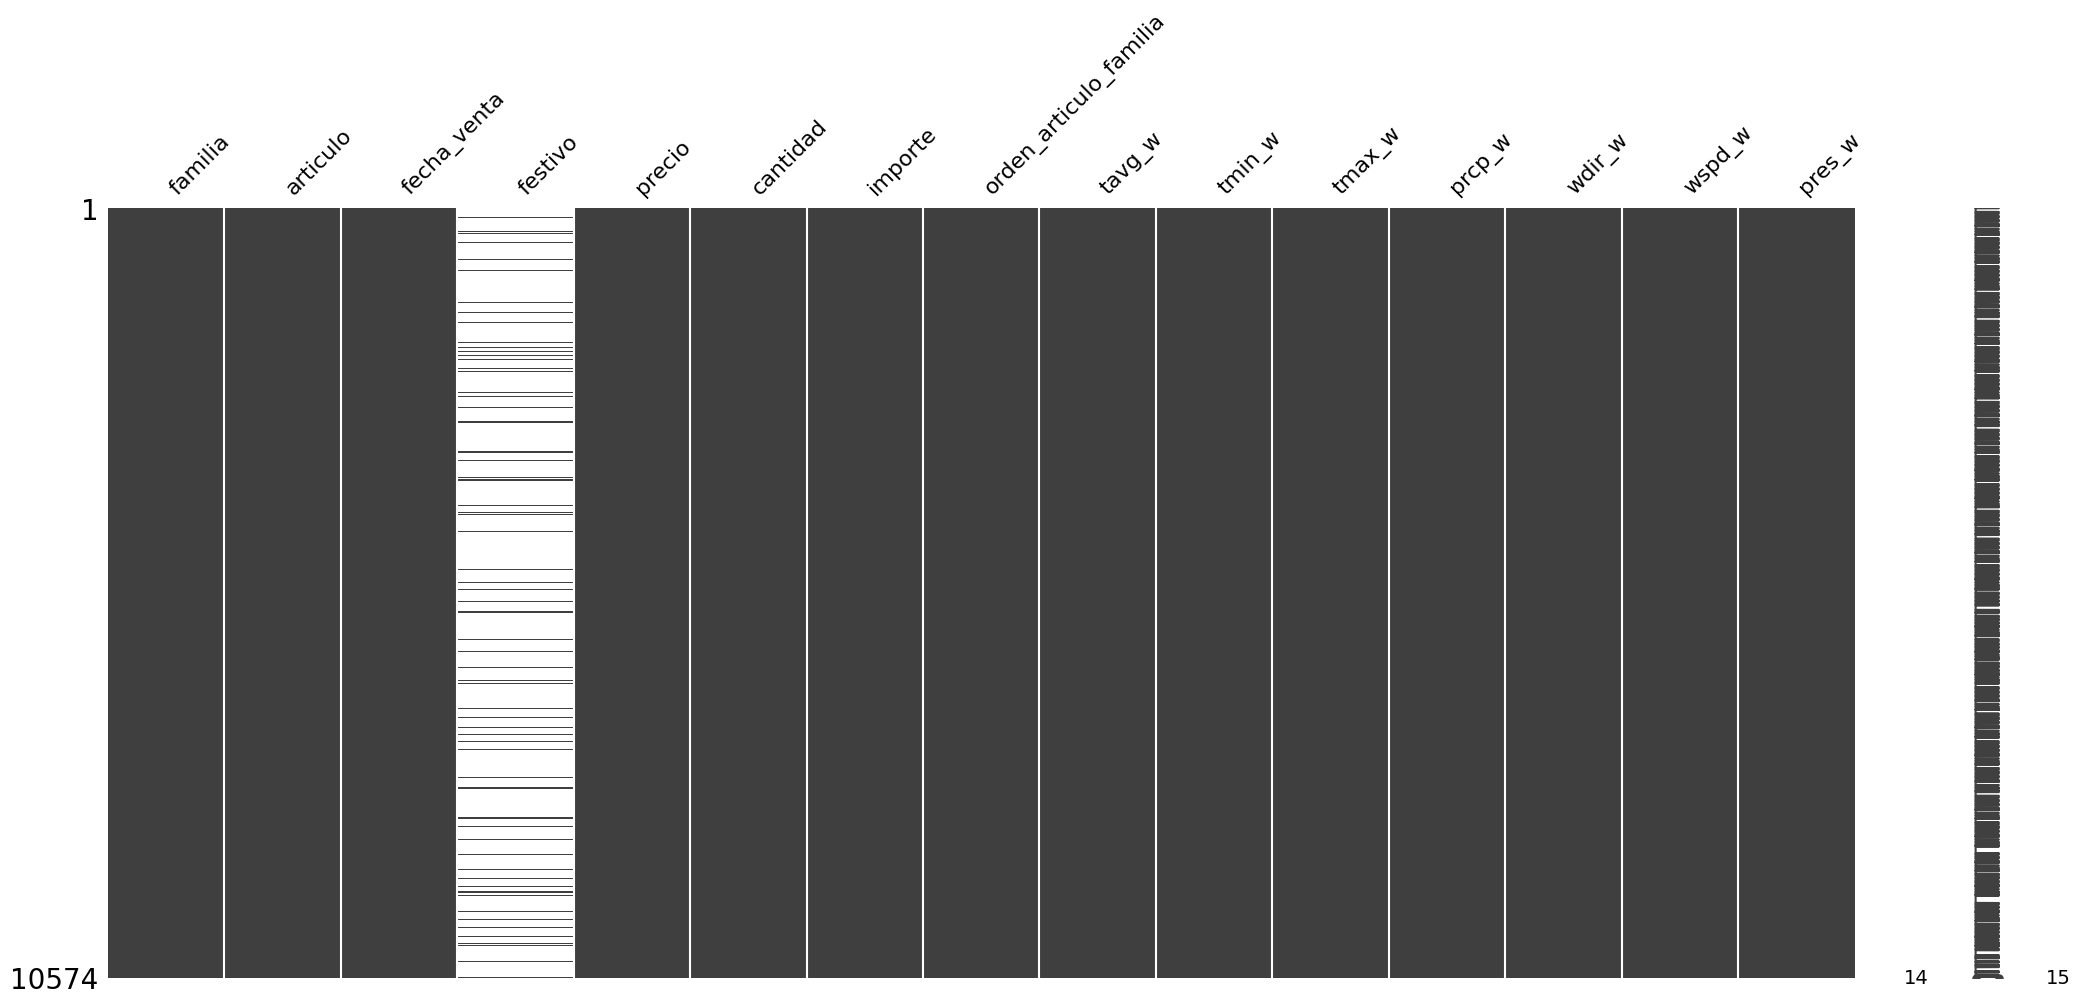

In [12]:
# 3
# Valores nulos

msno.matrix(df)

In [25]:
#3. Otra forma de ver los nulos (en porcentaje)
df.isnull().sum()/len(df) * 100

familia                    0.000000
articulo                   0.000000
fecha_venta                0.000000
festivo                   92.084358
precio                     0.000000
cantidad                   0.000000
importe                    0.000000
orden_articulo_familia     0.000000
tavg_w                     0.000000
tmin_w                     0.000000
tmax_w                     0.000000
prcp_w                     0.000000
wdir_w                     0.000000
wspd_w                     0.000000
pres_w                     0.000000
dtype: float64

In [26]:
# 4
# Valores duplicados

df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]
#df.drop_duplicates(['fecha_venta', 'articulo'])

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w


**Grupo de preguntas 2** (x minutos):

5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [34]:
# 5
# Rango de fechas del conjunto de datos

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}. ",
      f"Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-05-18 00:00:00.  Lo que supone 747 days 00:00:00


In [35]:
# 5
# Fechas faltantes

# Extraemos los ids únicos de los artículos
unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

# Generamos una variable con el rango de fechas de nuestro estudio
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    #Filtramos el df por el articulo en cuestión
    #subset = df.query("articulo == @article")
    subset = df[df['articulo'] == article]
    family = subset["familia"].unique().tolist()[0]

    # Vemos si hay alguna fecha de este subset que no esté en el rango completo de fechas (sería una fecha faltante)
    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PASTELERIA -> Articulo 5404 -> Fechas faltantes 98
PASTELERIA -> Articulo 6523 -> Fechas faltantes 49
PASTELERIA -> Articulo 5403 -> Fechas faltantes 107
PASTELERIA -> Articulo 6451 -> Fechas faltantes 74
PASTELERIA -> Articulo 6549 -> Fechas faltantes 312


<Axes: xlabel='fecha_venta', ylabel='cantidad'>

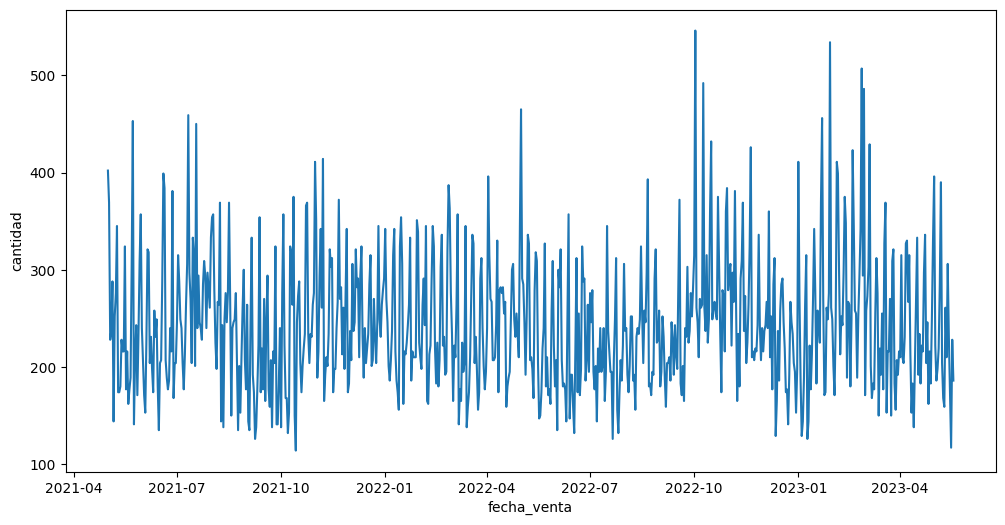

In [39]:
# 5
# Gráfico de la cantidad del producto "3960"

articulo = 3960
filtered_df = df[df['articulo'] == articulo]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='fecha_venta', y='cantidad')

#Como el gráfico es a nivel día, se ven muchos data points


<Axes: xlabel='None', ylabel='cantidad'>

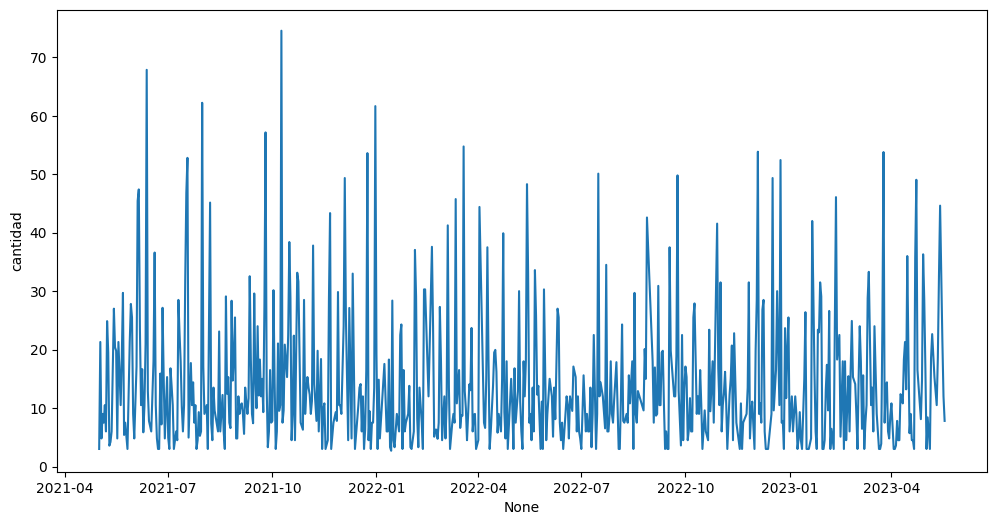

In [41]:
articulo = 5403
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x=filtered_df.index, y='cantidad')


In [45]:
# 6
# Outliers en cantidad desglosando por producto

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df[df['articulo'] == articulo]
    family = subset['familia'].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 5803 -> Outliers 53
BOLLERIA -> Articulo 6286 -> Outliers 59
BOLLERIA -> Articulo 6425 -> Outliers 25
BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 3880 -> Outliers 36
PANADERIA -> Articulo 1043 -> Outliers 36
PANADERIA -> Articulo 968 -> Outliers 28
PANADERIA -> Articulo 900 -> Outliers 30
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 1084 -> Outliers 5
PASTELERIA -> Articulo 5404 -> Outliers 25
PASTELERIA -> Articulo 6523 -> Outliers 36
PASTELERIA -> Articulo 5403 -> Outliers 37
PASTELERIA -> Articulo 6451 -> Outliers 24
PASTELERIA -> Articulo 6549 -> Outliers 3


<Axes: xlabel='cantidad'>

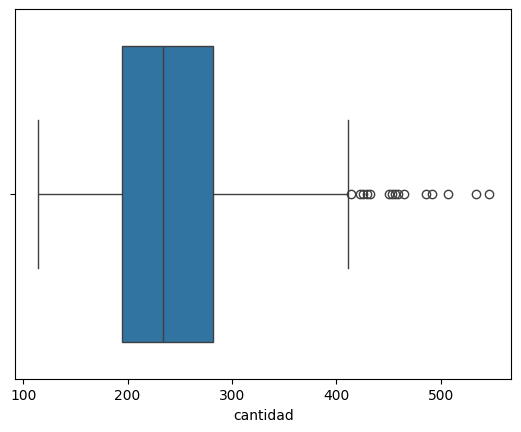

In [44]:
articulo_3960 = df[df['articulo'] == 3960]
sns.boxplot(data=articulo_3960, x='cantidad')

*****

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

<Axes: xlabel='fecha_venta', ylabel='cantidad'>

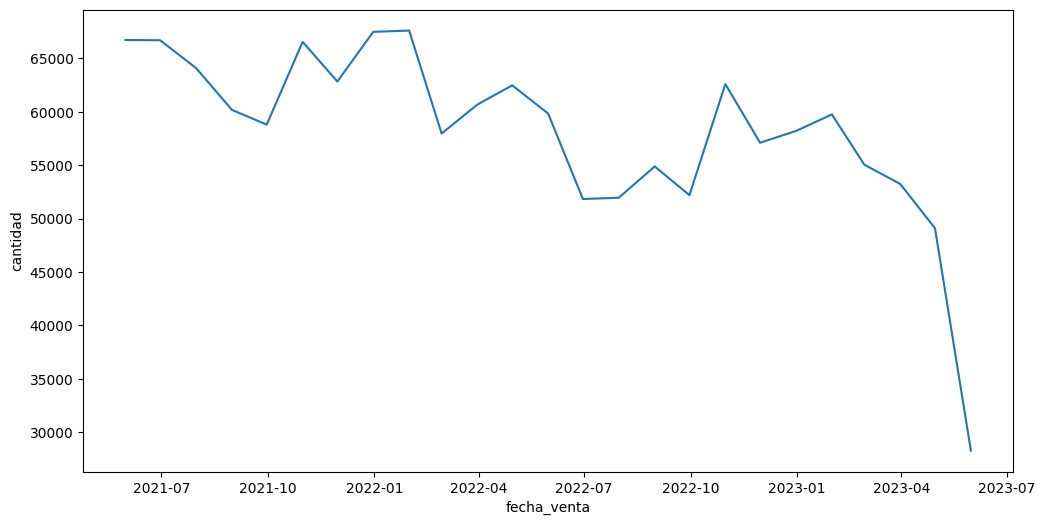

In [49]:
# 7
# Evolución temporal general de la variable "cantidad"
# En "freq" se puede especificar a nivel dia, mes, año...

# group = df.groupby(pd.Grouper(key="fecha_venta", freq="D"))["cantidad"].sum().reset_index()
group = df.groupby(pd.Grouper(key="fecha_venta", freq="M"))["cantidad"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad')

<Figure size 1200x600 with 0 Axes>

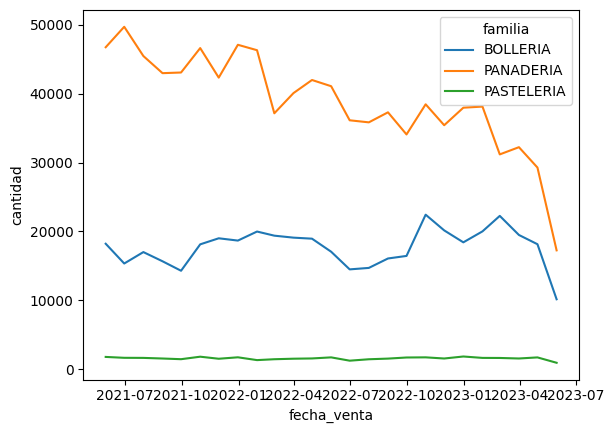

<Figure size 1200x600 with 0 Axes>

In [52]:
# 8
# Evolución temporal por familia de la variable "cantidad"

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="M")])["cantidad"].sum().reset_index()
sns.lineplot(data=group, x='fecha_venta', y='cantidad', hue='familia')
plt.figure(figsize=(12, 6))

<Axes: xlabel='fecha_venta', ylabel='cantidad'>

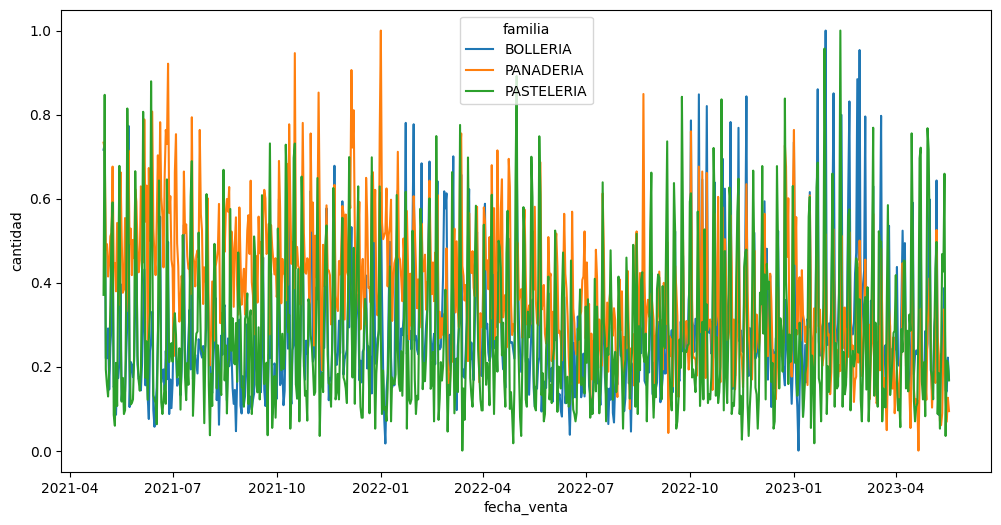

In [55]:
# 8
# Evolución temporal por familia de la variable "cantidad", normalizada para poder comparar

scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
plt.figure(figsize=(12, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', hue='familia')

<Axes: xlabel='fecha_venta', ylabel='cantidad'>

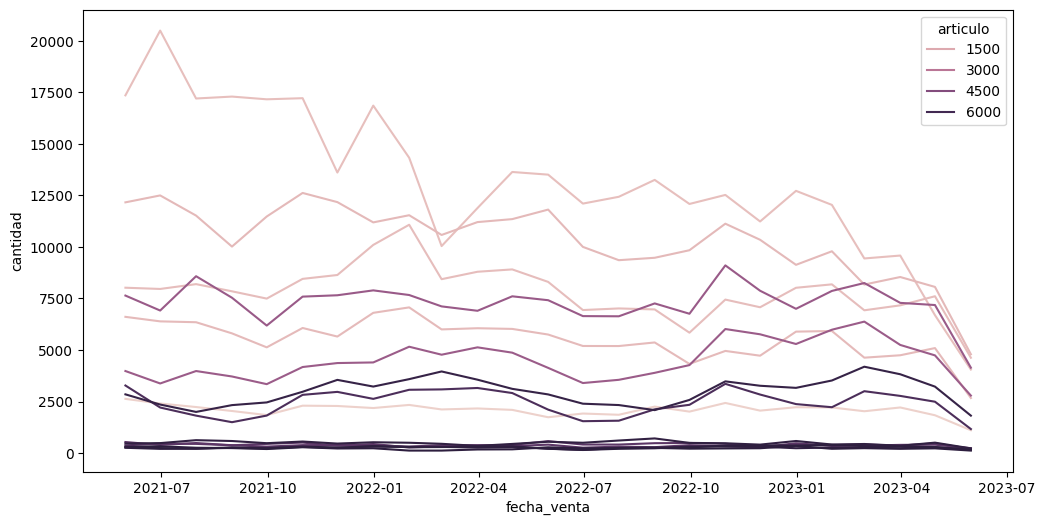

In [60]:
# 9
# Evolución temporal por artículo de la variable "cantidad"

group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="ME")])["cantidad"].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', hue='articulo') 

#Hay demasiado ruido!

**Grupo de preguntas 4** (x minutos):

11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

ADF Statistic:  -1.4110271943456103
p-value:  0.5769782744361363
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Non-stationary 


<Axes: xlabel='fecha_venta', ylabel='cantidad'>

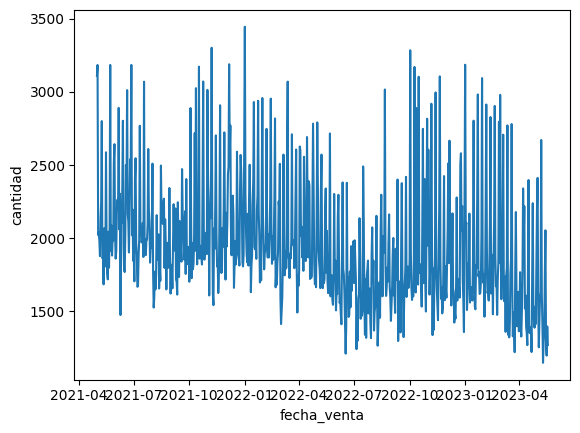

In [64]:
# 11
# Check si el proceso es estacionario: prueba de Dickey-Fuller aumentada (ADF)
# La estacionariedad es una propiedad clave en el análisis de series temporales, 
# y significa que las propiedades estadísticas de la serie (como la media y la varianza) son constantes en el tiempo.

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
sns.lineplot(data=group, x='fecha_venta', y='cantidad')

In [65]:
# 11
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.58110464050676
p-value:  1.9096088838137346e-23
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Stationary 


<Axes: xlabel='fecha_venta', ylabel='cantidad_diff'>

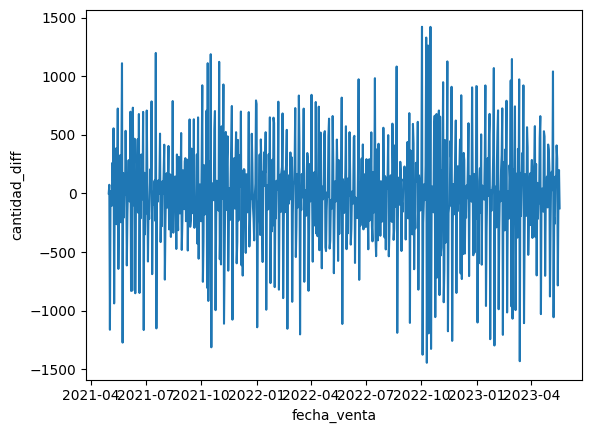

In [66]:
# 11
# La nueva serie temporal tiene esta pinta

sns.lineplot(data=group, x='fecha_venta', y='cantidad_diff')


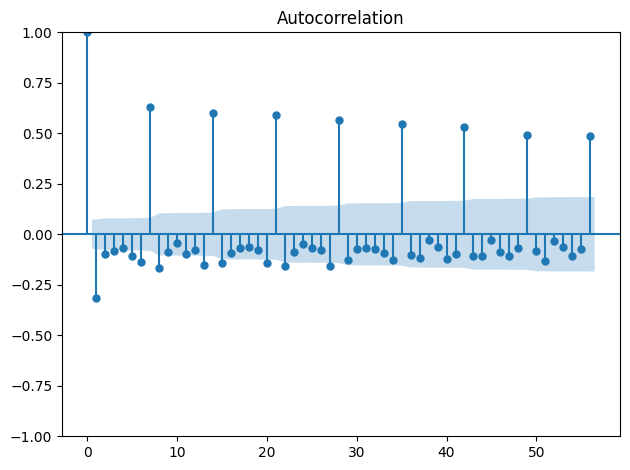

In [ ]:
# 11
# Analisis de autocorrelación

# En terminos generales, este gráfico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

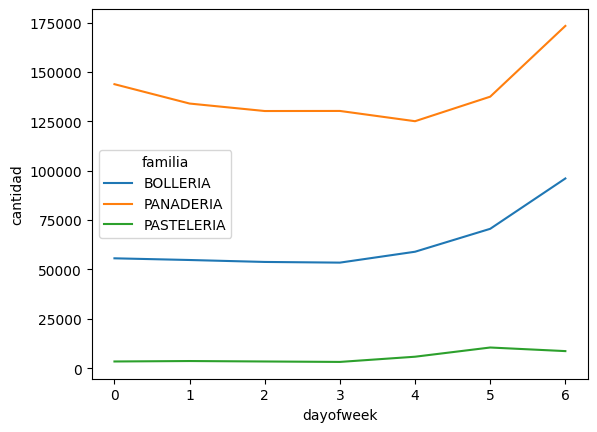

In [68]:
# 12

# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.dayofweek #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    sns.lineplot(data=group, x=freq, y='cantidad', hue=breakdown, markers=True)
    

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro análisis de autocorrelación,
# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

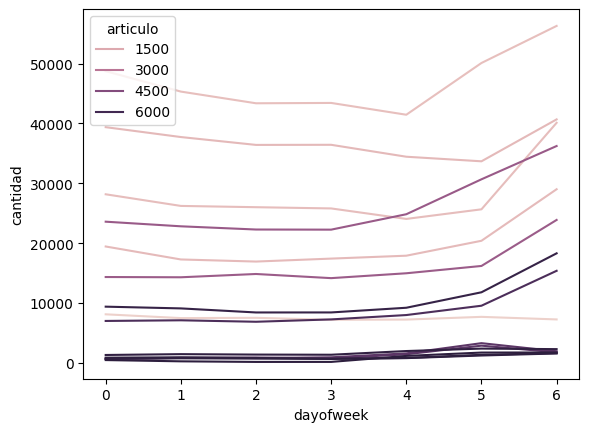

In [69]:
# 12

# A nivel articulo
graph_by_freq("dayofweek", "articulo")

<Axes: xlabel='dayofweek', ylabel='cantidad'>

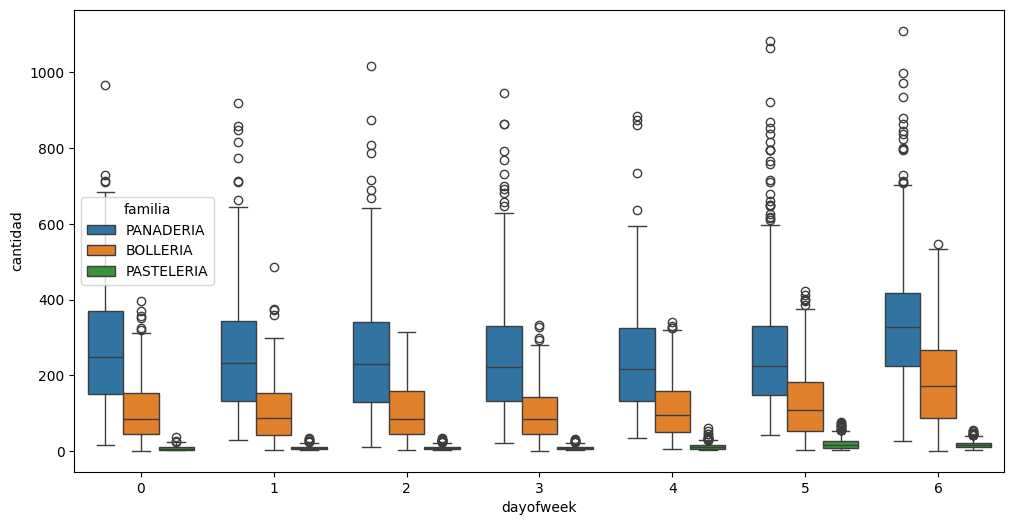

In [72]:
# 12
# Gráficos caja
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='dayofweek', y='cantidad', hue='familia')

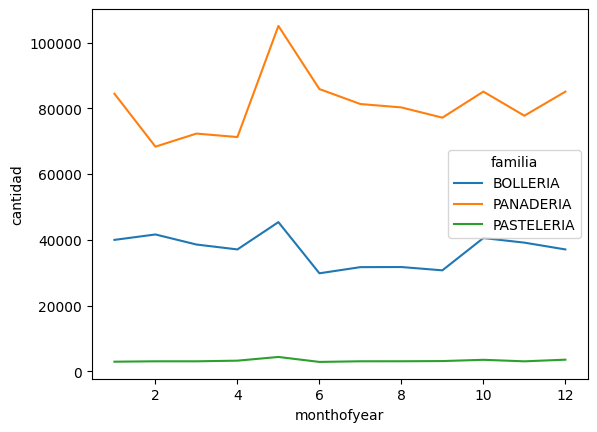

In [73]:
graph_by_freq("monthofyear")

*****

#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

<Axes: xlabel='es_festivo', ylabel='cantidad'>

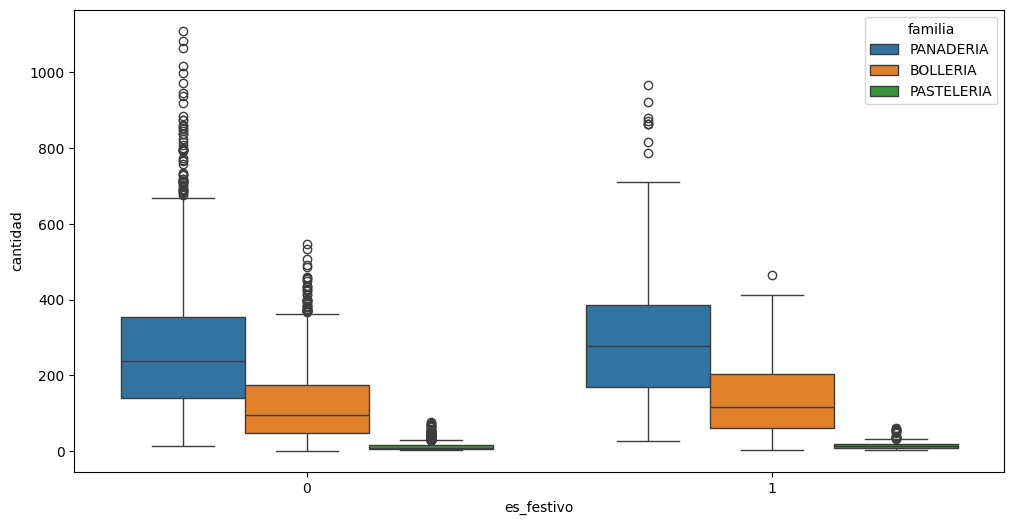

In [74]:
# 13

# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='es_festivo', y='cantidad', hue='familia')

# El comportamiento de compra cuando es festivo parece ligeramente superior

<Axes: xlabel='lluvia', ylabel='cantidad'>

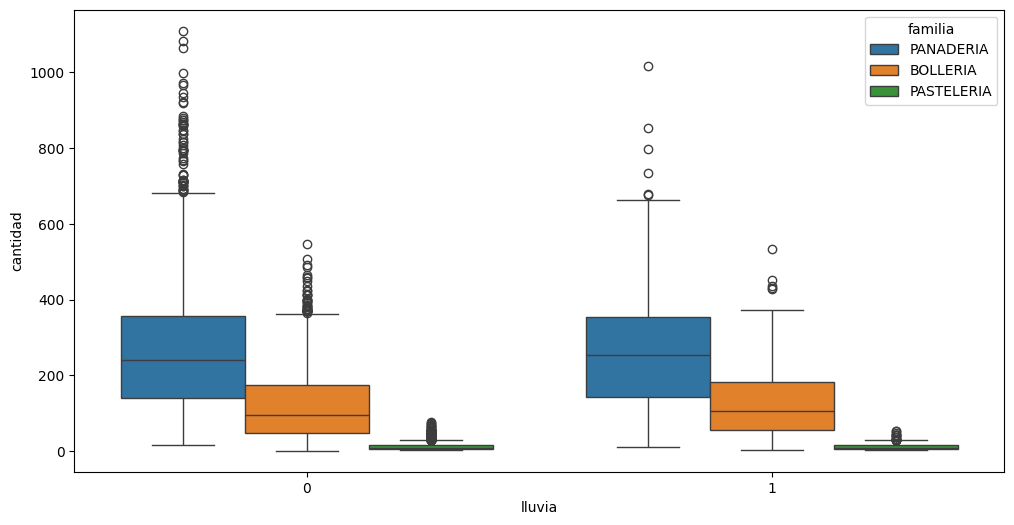

In [75]:
# 14

# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='lluvia', y='cantidad', hue='familia')

# Parece que la lluvia no es un impedimiento para comprar

<Axes: xlabel='quintiles_tavg_w', ylabel='cantidad'>

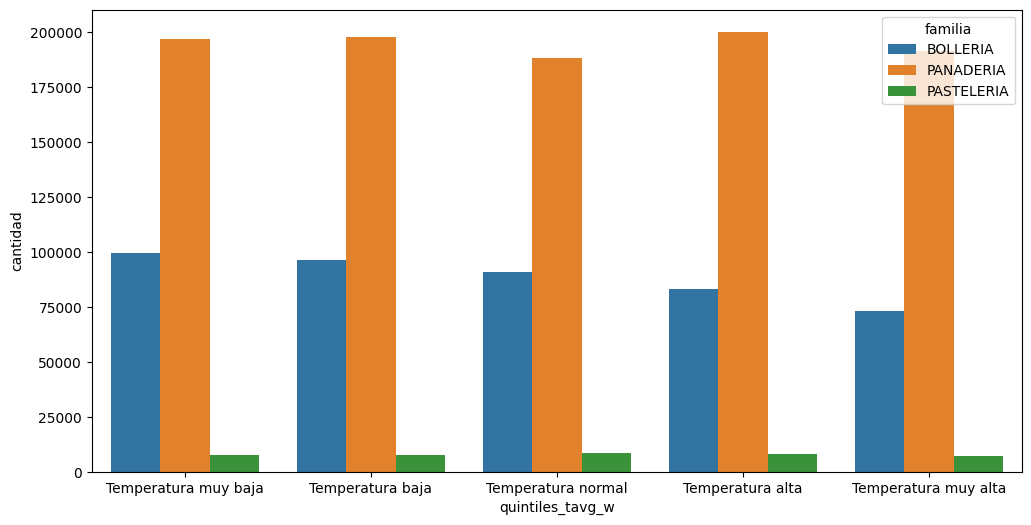

In [77]:
# 15

labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=group, x='quintiles_tavg_w', y='cantidad', hue='familia')
#fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
#fig.show()

**Grupo de preguntas 6** (x minutos):

16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

<Axes: xlabel='precio', ylabel='cantidad'>

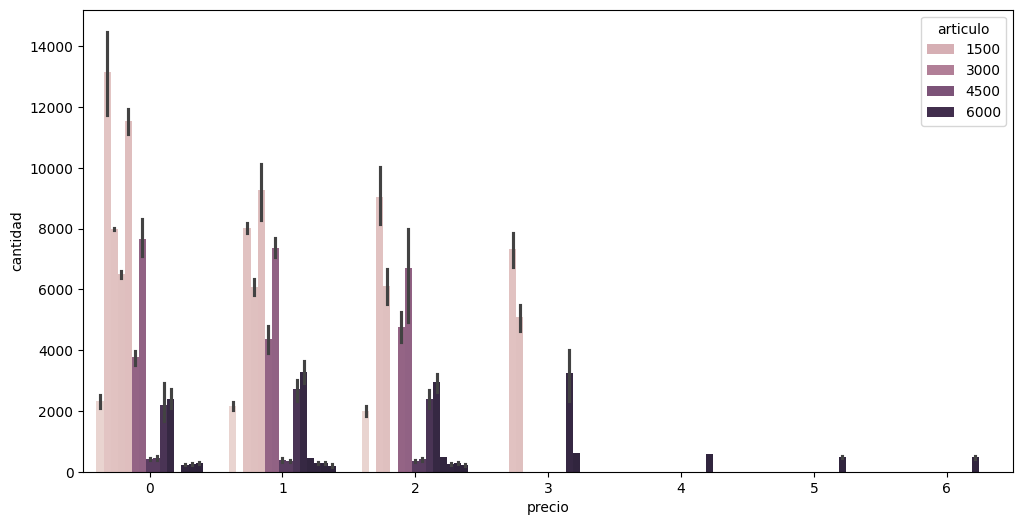

In [78]:
# 16

def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

plt.figure(figsize=(12, 6))
sns.barplot(data=group, x='precio', y='cantidad', hue='articulo')
#fig = px.box(group, x="precio", y="cantidad", color='articulo')
#
# fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podría ser también por la canibalización de nuevos productos a otros anteriores.

*****